## Utility Functions

In [46]:
import networkx as nx
import time
import tracemalloc
import random
import sys
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import pandas as pd
import math

def create_sample_graph(n=100, p=0.1, seed=42, weighted=True):
    """Creates a sample Erdős-Rényi graph."""
    print(f"Creating sample graph G (n={n}, p={p})...")
    G_sample = nx.erdos_renyi_graph(n, p, seed=seed, directed=False)
    # Ensure graph is connected (or mostly connected for sparse graphs)
    # Add edges to connect components if needed
    if not nx.is_connected(G_sample):
        components = list(nx.connected_components(G_sample))
        if len(components) > 1:
            print(f"Graph is not connected ({len(components)} components). Adding edges...")
            for i in range(len(components) - 1):
                u = random.choice(list(components[i]))
                v = random.choice(list(components[i+1]))
                if not G_sample.has_edge(u,v):
                    G_sample.add_edge(u, v)

    if weighted:
        random.seed(seed)
        for u, v in G_sample.edges():
            G_sample[u][v]['weight'] = random.uniform(1.0, 10.0)
        print("Added random weights to edges.")
    else:
         for u, v in G_sample.edges():
            G_sample[u][v]['weight'] = 1 # Default weight for unweighted cases if needed

    # Ensure nodes are 0 to n-1 if erdos_renyi_graph doesn't guarantee it
    nodes = list(G_sample.nodes())
    if set(nodes) != set(range(n)):
        mapping = {old_node: i for i, old_node in enumerate(nodes)}
        G_sample = nx.relabel_nodes(G_sample, mapping)
        print("Relabeled nodes to be 0 to n-1.")

    print(f"Sample graph created with {G_sample.number_of_nodes()} nodes and {G_sample.number_of_edges()} edges.")
    return G_sample


class UnionFind:
    """Simple Union-Find implementation."""
    def __init__(self, n):
        self.parent = list(range(n))
        self.rank = [0] * n
        self.num_nodes = n

    def find(self, i):
        if self.parent[i] == i:
            return i
        self.parent[i] = self.find(self.parent[i])  # Path compression
        return self.parent[i]

    def union(self, i, j):
        root_i = self.find(i)
        root_j = self.find(j)
        if root_i != root_j:
            # Union by rank
            if self.rank[root_i] < self.rank[root_j]:
                self.parent[root_i] = root_j
            elif self.rank[root_i] > self.rank[root_j]:
                self.parent[root_j] = root_i
            else:
                self.parent[root_j] = root_i
                self.rank[root_i] += 1
            return True
        return False


def measure_memory(func, *args, **kwargs):
    """Measures peak memory usage of a function call using tracemalloc."""
    tracemalloc.start()
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    elapsed_time = end_time - start_time
    # Peak memory is more indicative of the algorithm's space requirement
    return result, elapsed_time, peak


Creating sample graph G (n=50, p=0.6)...
Added random weights to edges.
Sample graph created with 50 nodes and 720 edges.


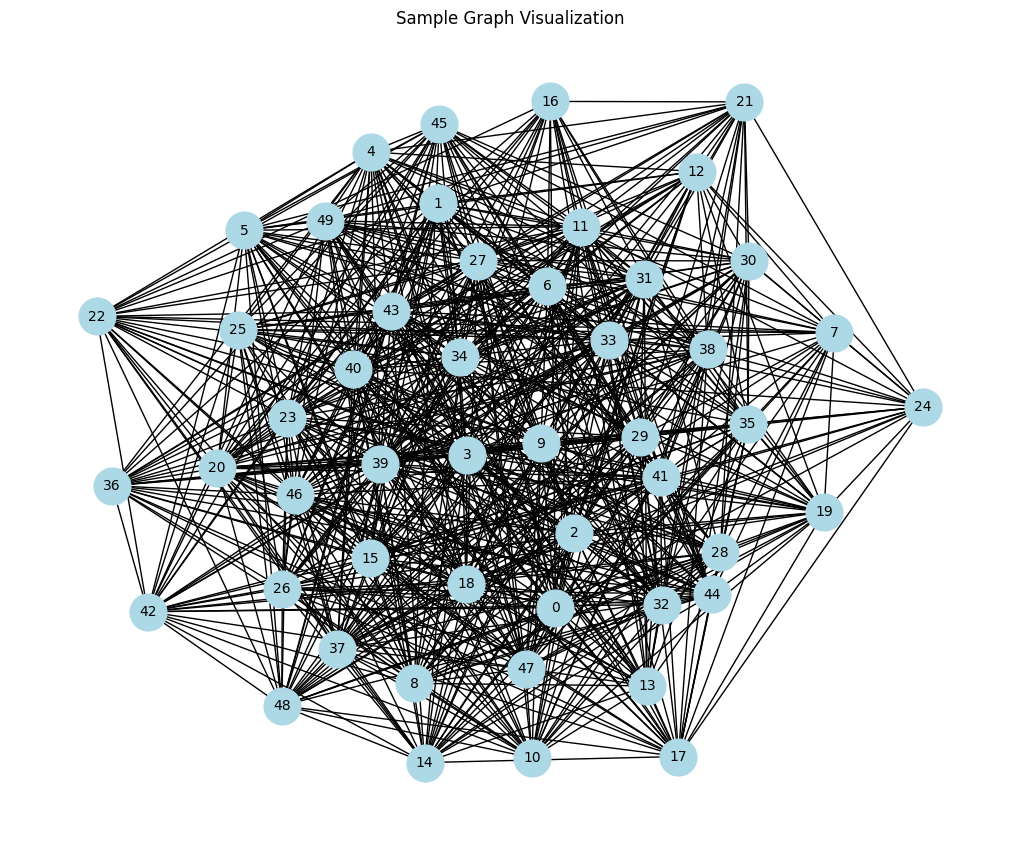

In [47]:
# G = nx.read_edgelist(
#     './dataset/twitch/DE/musae_DE_edges.csv',
#     delimiter=',',
#     nodetype=int,
#     data=(('weight', float),)
# )
# G = nx.Graph(G)
# print(G)

G = create_sample_graph(n=50, p=0.6, seed=42, weighted=True)



def plot_graph(G, title="Graph Visualization"):
    """Plots the graph using matplotlib."""
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=700, node_color='lightblue', font_size=10)
    # edge_labels = nx.get_edge_attributes(G, 'weight')
    # nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title(title)
    plt.show()
    
plot_graph(G, title="Sample Graph Visualization")

# Streaming Algorithms

### Connectivity

Pseudo Code 
1) Initialize an empty edge set H
2) Initialize an empty vertex set V_seen
3) For each edge {u, v} in stream S:
4)     If there is no path between u and v in H:
5)         Add edge {u, v} to H
6)     Add u and v to V_seen
7) If number of connected components in H == 1 and 
     size of V_seen == number of vertices in the original graph:
8)     Return "Graph is connected"

Using Union Find algorithm
Time complexity = $O(m \alpha (n))$

Space complexity 
Edges set H : stores up to n - 1 edges O(n)
Edges set Vseen:stores up to n vertices O(n)


Graph has 50 nodes and 49 edges.


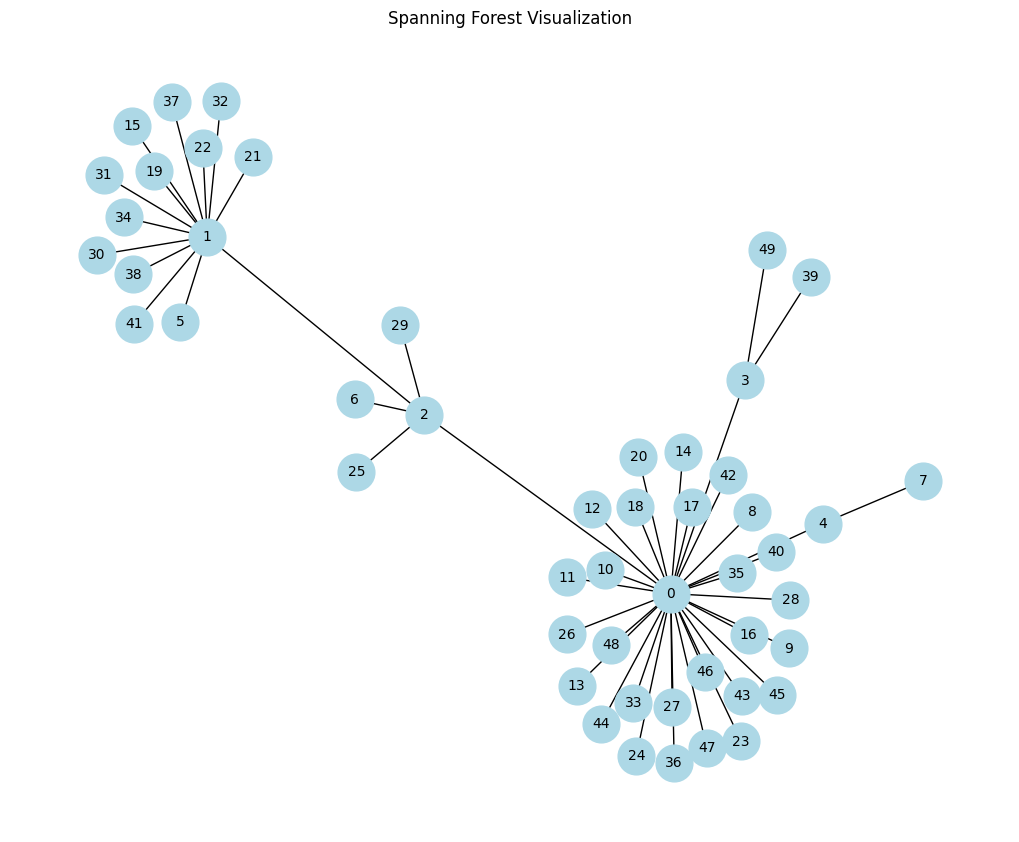

In [48]:
def run_connectivity(stream, n):
    """
    Constructs a spanning forest using Union-Find.
    Space: O(n) for UF + O(n) for edges = O(n)
    Time per edge: O(alpha(n)) for UF operations (alpha is inverse Ackermann, nearly constant)
    Total Time: O(m * alpha(n))
    """
    uf = UnionFind(n)
    spanning_forest_edges = []
    nodes_seen = set()

    for u, v, _ in stream: # Ignore weight for connectivity
        nodes_seen.add(u)
        nodes_seen.add(v)
        # Ensure UF is initialized for nodes up to max(u, v) if n wasn't exact
        # This check is less critical if n >= max node id in stream
        if max(u, v) >= uf.num_nodes:
             # This scenario shouldn't happen if n is correctly the max node id + 1
             print(f"Warning: Edge ({u},{v}) exceeds initial n={uf.num_nodes}. This indicates an issue.")
             continue # Skip edge or resize UF (resizing is complex here)

        if uf.union(u, v):
            spanning_forest_edges.append(tuple(sorted((u, v))))

    # Create the resulting graph object (optional, for analysis)
    H = nx.Graph()
    H.add_nodes_from(range(n)) # Add all potential nodes
    H.add_edges_from(spanning_forest_edges)
    return H, len(spanning_forest_edges) # Return graph and edge count


graph_temp,edge_count = run_connectivity(G.edges(data=True), G.number_of_nodes())
print(f"Graph has {graph_temp.number_of_nodes()} nodes and {graph_temp.number_of_edges()} edges.")

plot_graph(graph_temp, title="Spanning Forest Visualization")

### Spanner

PseudoCodee

1) Initialize an empty edge set H
2) For each edge {u, v} in the stream S:
    - If the distance between u and v in H > α:
        - Add edge {u, v} to H
5) Return H


Space Complexity
- O(n) Nodes
- O($n^{1+1/t}$) edges


Time complexity
- For each edge O(n +  $n^{1+1/t}$)
- Total time O(m * $n^{1+1/t}$)

Graph has 50 nodes and 49 edges.


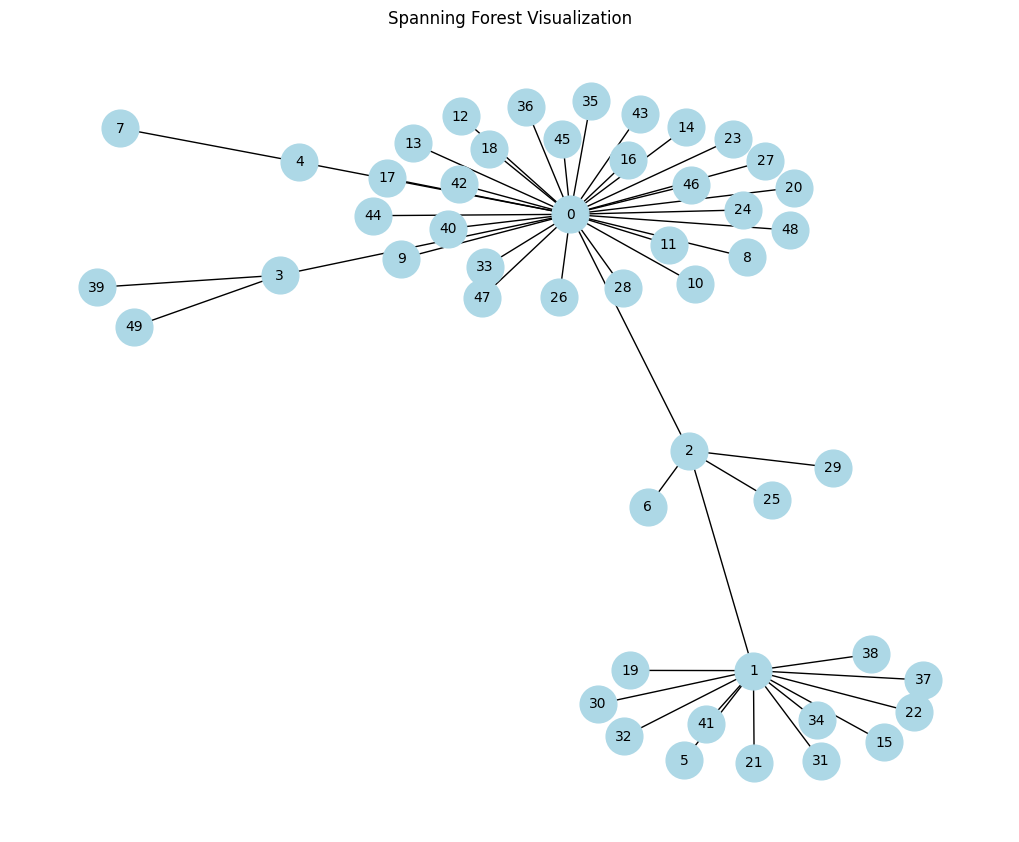

In [49]:
# 2. Spanner Construction (Algorithm 1)
def run_spanner(stream, n, alpha):
    """
    Constructs an alpha-spanner.
    Space: O(n^(1 + 1/t)) edges for alpha=2t-1. Graph representation adds overhead.
    Time per edge: Dominated by shortest path query dH(u,v). Naive BFS/Dijkstra is O(|V_H| + |E_H|).
                  Can be slow: O(m * (|V_H| + |E_H|)).
    """
    H = nx.Graph()
    H.add_nodes_from(range(n)) # Initialize with all potential nodes
    edge_count = 0

    for u, v, _ in stream: # Ignore weight for simple spanner definition
        # Check if nodes exist, add if not (though pre-adding is better)
        if u not in H: H.add_node(u)
        if v not in H: H.add_node(v)

        try:
            # Calculate shortest path distance in the *current* spanner H
            distance = nx.shortest_path_length(H, source=u, target=v)
            # Check if adding the edge would violate the spanner property too much
            if distance > alpha:
                H.add_edge(u, v)
                edge_count += 1
        except nx.NetworkXNoPath:
            # If no path exists, the distance is effectively infinite > alpha
            H.add_edge(u, v)
            edge_count += 1
        except nx.NodeNotFound:
             # This shouldn't happen if nodes are pre-added or added dynamically
             print(f"Warning: Node not found during spanner construction for edge ({u},{v}).")
             # Decide how to handle: maybe add nodes first?
             if u not in H: H.add_node(u)
             if v not in H: H.add_node(v)
             # Assume distance is infinite if nodes were missing
             H.add_edge(u, v)
             edge_count += 1


    return H, edge_count # Return the spanner graph and its edge count

graph_temp,edge_count = run_connectivity(G.edges(data=True), G.number_of_nodes())
print(f"Graph has {graph_temp.number_of_nodes()} nodes and {graph_temp.number_of_edges()} edges.")


def get_connected_subgraph(G, start_node, size):
    visited = set()
    queue = [start_node]

    while queue and len(visited) < size:
        node = queue.pop(0)
        if node not in visited:
            visited.add(node)
            queue.extend([n for n in G.neighbors(node) if n not in visited])

    return G.subgraph(visited)



plot_graph(graph_temp, title="Spanning Forest Visualization")


### MST

There are two approaches one using union find and another using the cycle property

 Algorithm 2: MST (Kruskal-style)

1. `H ← ∅`  
2. Sort all edges in `S` by weight  
3. Initialize Union-Find on `n` nodes  
4. **for each** `{u, v, w} ∈ S` in sorted order **do**  
5. &nbsp;&nbsp;&nbsp;&nbsp;**if** `u` and `v` are in different components **then**  
6. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`H ← H ∪ {{u, v, w}}`  
7. **return** `H`


Time Complexity 
sorting: O(mlogm) m is hte number of edges
for union and find part for m edges : o(m acerman(n)) log m > log n


Graph has 50 nodes and 49 edges.


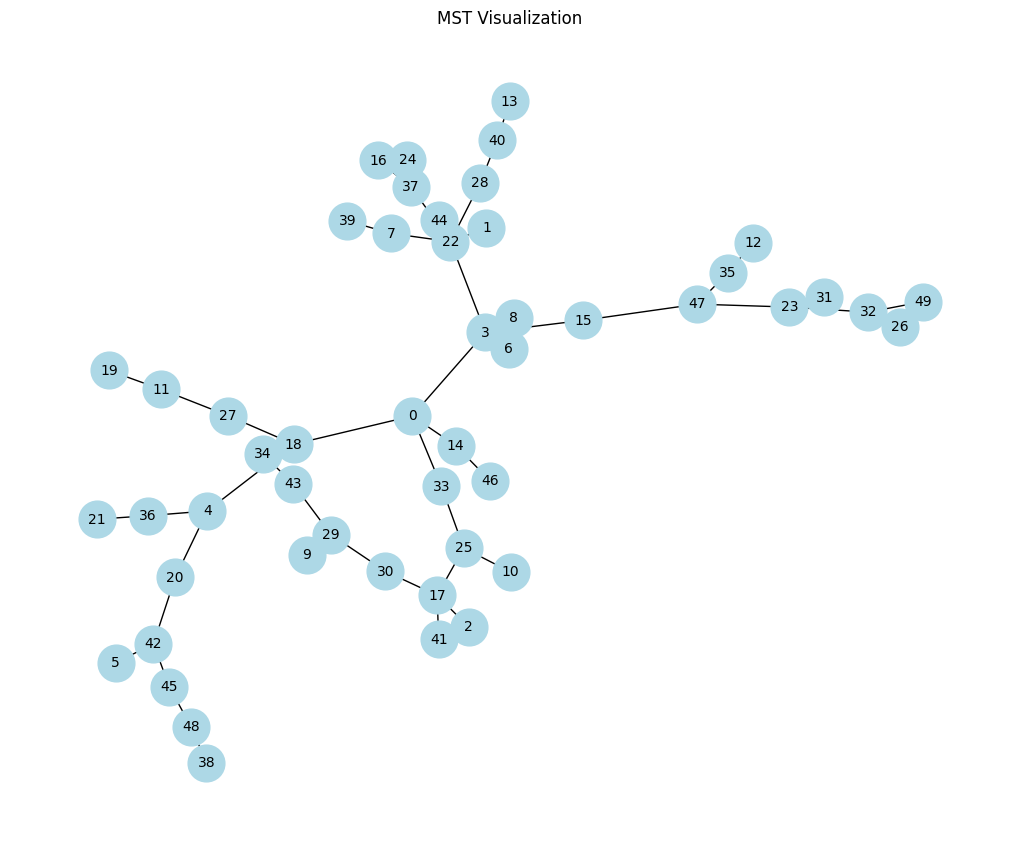

In [50]:
def run_mst(stream, n):
    """
    Kruskal-style MST using Union-Find.
    Time: O(m log m) due to sorting.
    Space: O(n)
    """
    H = nx.Graph()
    H.add_nodes_from(range(n))

    # Sort the edges by weight
    sorted_stream = sorted(stream, key=lambda x: x[2].get('weight', 1))

    uf = UnionFind(n)
    edge_count = 0

    for u, v, data in sorted_stream:
        weight = data.get('weight', 1)
        if uf.union(u, v):  # Only add if it doesn't form a cycle
            H.add_edge(u, v, weight=weight)
            edge_count += 1

    return H, edge_count


def run_mst_cycle(stream, n):
    """
    Constructs an MST/MSF using the cycle property.
    Space: O(n) edges stored in H.
    Time per edge: Add edge O(1). Find cycle can be O(n) with DFS/BFS. Total O(m*n).
                   Faster with dynamic connectivity (O(log n) or O(log^2 n) amortized).
                   We use NetworkX find_cycle which might vary in performance.
    """
    H = nx.Graph()
    H.add_nodes_from(range(n))
    edge_count = 0

 

    for u, v, data in stream:
        weight = data.get('weight', 1) # Default weight 1 if missing
        
        # Add edge temporarily or permanently
        H.add_edge(u, v, weight=weight)
        edge_count += 1 # Tentatively count

        try:
            # Check if adding the edge created a cycle
            # find_cycle might be slow. It finds *a* cycle.
            cycle_edges = nx.find_cycle(H, source=u) # Check cycle involving u

            # If a cycle is found
            max_weight_edge = None
            max_weight = -float('inf')

            # Iterate through edges in the cycle path
            for edge in cycle_edges:
                u_cycle, v_cycle = edge[0], edge[1]
                # Handle potential directionality if find_cycle returns directed edges
                if H.has_edge(u_cycle, v_cycle):
                    w = H[u_cycle][v_cycle].get('weight', 1)
                    if w > max_weight:
                        max_weight = w
                        # Store edge canonically
                        max_weight_edge = tuple(sorted((u_cycle, v_cycle)))
                else:
                     # Should not happen with undirected cycle find on undirected graph
                     print(f"Warning: Edge {edge} from cycle not found in H.")


            if max_weight_edge:
                 # Remove the heaviest edge in the cycle
                 u_rem, v_rem = max_weight_edge
                 if H.has_edge(u_rem, v_rem):
                    H.remove_edge(u_rem, v_rem)
                    edge_count -= 1
                 else:
                     # This should not happen if max_weight_edge came from H
                     print(f"Warning: Trying to remove non-existent edge {max_weight_edge}")

        except nx.NetworkXNoCycle:
            # No cycle formed by adding the edge, keep it.
            pass
        except nx.NodeNotFound:
            # Should not happen if nodes pre-added
            print(f"Warning: Node not found during MST cycle check for edge ({u},{v}).")


    return H, edge_count


graph_temp,edge_count = run_mst(G.edges(data=True), G.number_of_nodes())
print(f"Graph has {graph_temp.number_of_nodes()} nodes and {graph_temp.number_of_edges()} edges.")


plot_graph(graph_temp, title="MST Visualization")


### Greedy matching

pseudo code for Greedy Matching
2 - approx solution

1. **Initialize** an empty matching: `M ← ∅`
2. **For each** edge `e ∈ S` do:
   - If `M ∪ {e}` is still a valid matching, then:
     - `M ← M ∪ {e}`
3. **Return** `M`

**Time:** \(O(m)\) for the single‐pass matching (constant work per edge), or \(O(m + n)\) if you include the \(n\)-node graph construction.  
**Space:** \(O(n)\) (for the matched‑nodes set, the matching \(M\), and the optional graph).

Graph has 50 nodes and 24 edges.


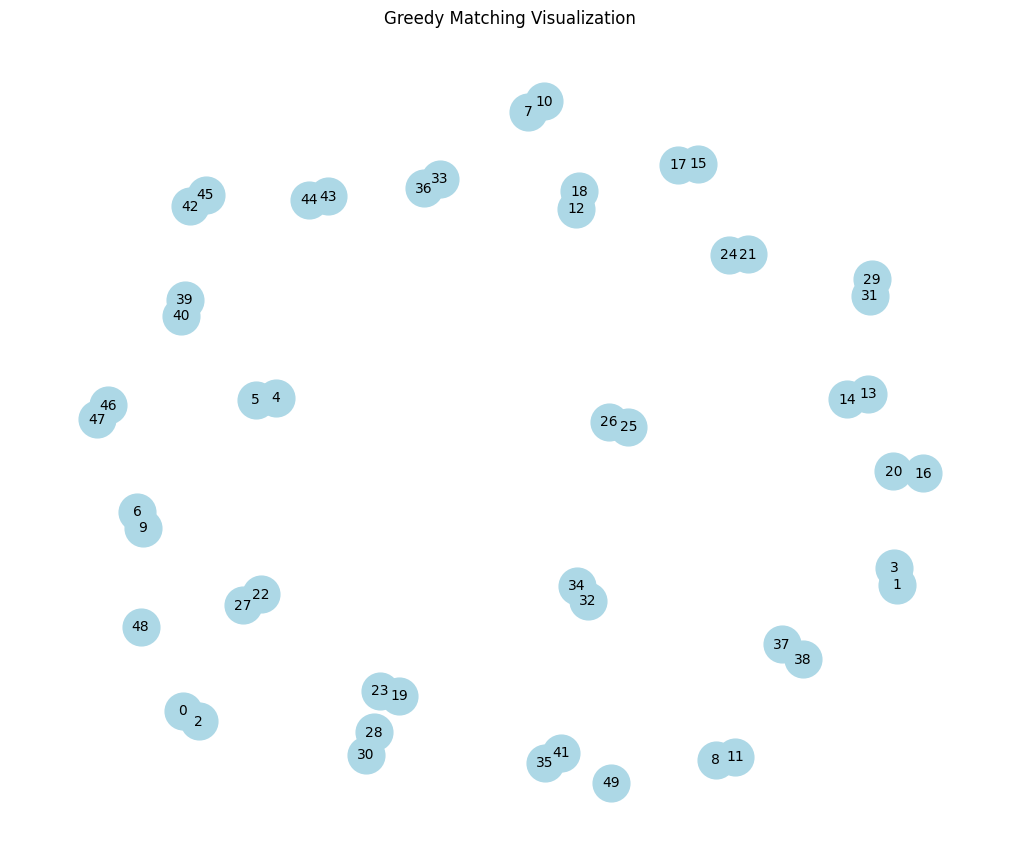

In [51]:
# 4. Greedy Matching (Algorithm 3)
def run_greedy_matching(stream, n):
    """
    Constructs a 2-approximate maximum cardinality matching greedily.
    Space: O(n) for matched_nodes set and O(n) for M edges. Total O(n).
    Time per edge: O(1) average for set lookups. Total O(m).
    """
    matched_nodes = set()
    M = [] # List of edge tuples

    for u, v, _ in stream: # Ignore weight
        if u not in matched_nodes and v not in matched_nodes:
            M.append(tuple(sorted((u, v))))
            matched_nodes.add(u)
            matched_nodes.add(v)

    # Create graph object (optional)
    H = nx.Graph()
    H.add_nodes_from(range(n))
    H.add_edges_from(M)
    return H, len(M) # Return matching graph and number of edges

graph_temp,edge_count = run_greedy_matching(G.edges(data=True), G.number_of_nodes())
print(f"Graph has {graph_temp.number_of_nodes()} nodes and {graph_temp.number_of_edges()} edges.")


plot_graph(graph_temp, title="Greedy Matching Visualization")

### Greedy weighted matching

**Time:** \(O(m)\) for the single‐pass weighted matching (constant work per edge), or \(O(m + n)\) if you include the \(n\)-node graph build.  
**Space:** \(O(n)\) (for the node‐to‐edge map, weight map, matching set, and optional graph).

Graph has 50 nodes and 23 edges.


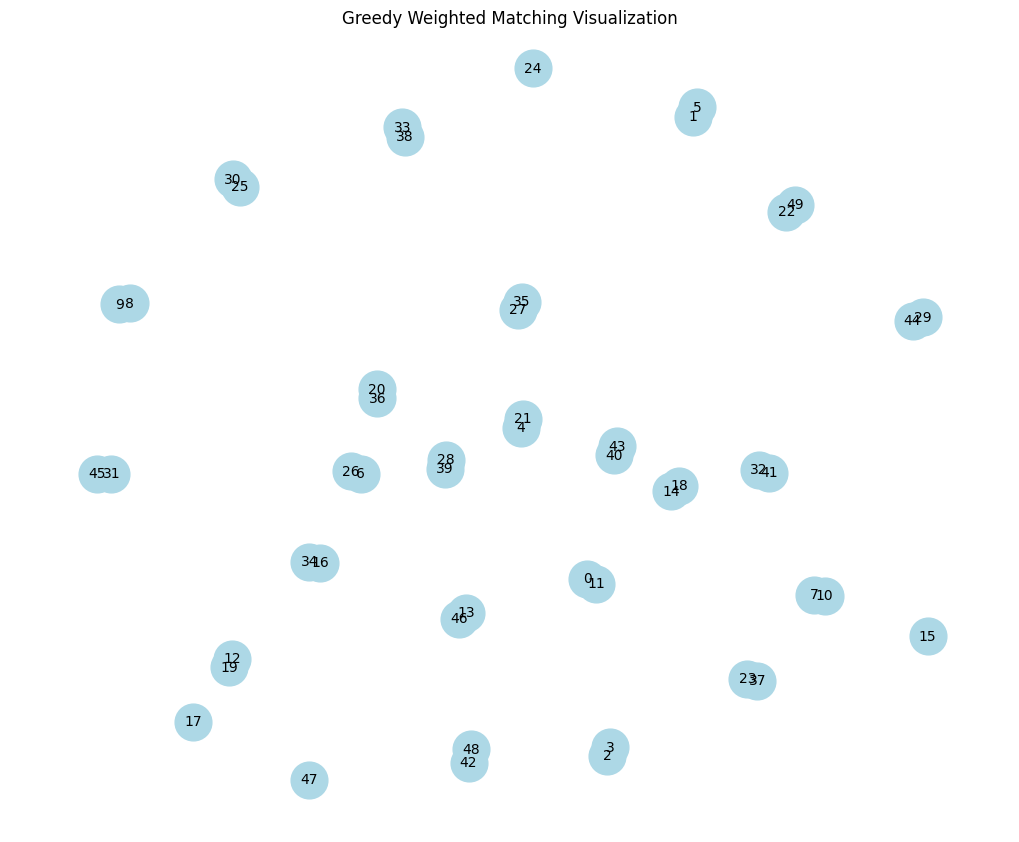

In [52]:

# 5. Greedy Weighted Matching (Algorithm 4)
def run_greedy_weighted_matching(stream, n, gamma=0.1):
    """
    Constructs an approx maximum weight matching greedily with replacement.
    Space: O(n) for node mapping, edge weights, matched edges. Total O(n).
    Time per edge: O(1) average for dict lookups/updates. Total O(m).
    Gamma must be > 0. If gamma=0, use a small epsilon like 1e-9.
    """
    if gamma <= 0:
        print("Warning: Gamma should be > 0 for Greedy Weighted Matching. Using 1e-9.")
        gamma = 1e-9

    node_to_edge_in_M = {} # node -> edge tuple (u,v)
    edge_weights_M = {}    # edge tuple (u,v) -> weight
    M_edges = set()         # set of edge tuples (u,v)

    for u, v, data in stream:
        edge = tuple(sorted((u, v)))
        weight = data.get('weight', 1) # Default weight 1 if missing

        conflicting_edges = set()
        if u in node_to_edge_in_M:
            conflicting_edges.add(node_to_edge_in_M[u])
        if v in node_to_edge_in_M:
            conflicting_edges.add(node_to_edge_in_M[v])

        w_C = sum(edge_weights_M.get(c_edge, 0) for c_edge in conflicting_edges)

        # Replacement condition
        # Use a small tolerance for floating point comparisons if necessary
        if weight >= (1 + gamma) * w_C:
            # Remove conflicting edges
            for c_edge in conflicting_edges:
                if c_edge in M_edges: # Check if it hasn't been removed already
                    c_u, c_v = c_edge
                    M_edges.remove(c_edge)
                    del edge_weights_M[c_edge]
                    if c_u in node_to_edge_in_M and node_to_edge_in_M[c_u] == c_edge:
                        del node_to_edge_in_M[c_u]
                    if c_v in node_to_edge_in_M and node_to_edge_in_M[c_v] == c_edge:
                        del node_to_edge_in_M[c_v]

            # Add the new edge
            M_edges.add(edge)
            edge_weights_M[edge] = weight
            node_to_edge_in_M[u] = edge
            node_to_edge_in_M[v] = edge

    # Create graph object (optional)
    H = nx.Graph()
    H.add_nodes_from(range(n))
    for edge, weight in edge_weights_M.items():
        H.add_edge(edge[0], edge[1], weight=weight)

    return H, len(M_edges) # Return matching graph and edge count

graph_temp,edge_count = run_greedy_weighted_matching(G.edges(data=True), G.number_of_nodes())
print(f"Graph has {graph_temp.number_of_nodes()} nodes and {graph_temp.number_of_edges()} edges.")


plot_graph(graph_temp, title="Greedy Weighted Matching Visualization")

### Triangle Counts



Here’s a summary of the time and space costs for each component in **triangle_counting.py**:

1. **`compute_moments(G)`**  
   - **Time**:  
     Iterates over all \(\binom{n}{3}\approx n^3/6\) triples and does \(O(1)\) work per triple ⇒ **\(O(n^3)\)**.  
   - **Space**:  
     Only a few counters (F₀, F₁, F₂) and loop variables ⇒ **\(O(1)\)** extra space.

2. **`exact_triangle_count(G)`**  
   - **Time**:  
     NetworkX’s `nx.triangles` runs in roughly \(O(m^{3/2})\) time (using node‐ordering heuristics) or at best \(O(n + m)\) for sparse graphs.  
   - **Space**:  
     Stores a size‑\(n\) dictionary of counts ⇒ **\(O(n)\)**.

3. **`estimate_triangles_moment(G)`**  
   - Simply calls `compute_moments` and then does constant‐time arithmetic ⇒  
     - **Time**: **\(O(n^3)\)**  
     - **Space**: **\(O(1)\)**  

4. **`estimate_triangles_l0(G, k)`**  
   - **Time**:  
     1. Build list of all triples with ≥1 edge: \(O(n^3)\).  
     2. Sample \(k\) triples, \(O(1)\) check each ⇒ \(O(k)\).  
     ⇒ **\(O(n^3 + k)\)**.  
   - **Space**:  
     Stores that list of triples (worst‐case size \(\binom{n}{3}\)) ⇒ **\(O(n^3)\)**.

In practice, the moment‐based routines are cubic in \(n\) but use constant extra space, whereas the \(\ell_0\)-sampling approach trades off space (to store all nonzero triples) for faster repeated sampling.





In [58]:
import itertools
import random
from typing import Iterable, Tuple

def compute_moments(stream: Iterable[Tuple[int, int]], n: int):
    """
    Compute the first three frequency moments for the vector x over triples T:
      - F0: number of triples with at least one edge
      - F1: m * (n - 2)
      - F2: sum_{triples T} x_T^2, where x_T is the number of edges in T

    Args:
        stream: iterable of (u, v) edges, nodes assumed labeled 0..n-1
        n: total number of nodes

    Returns:
        F0 (int), F1 (int), F2 (int)
    """
    # materialize edges into a canonical set
    edges = set()
    for u, v,_ in stream:
        if u == v:
            continue
        # store smaller first for consistency
        a, b = (u, v) if u < v else (v, u)
        edges.add((a, b))
    m = len(edges)
    F1 = m * (n - 2)

    F0 = 0
    F2 = 0

    # iterate over all triples of node‐IDs 0..n-1
    for u, v, w in itertools.combinations(range(n), 3):
        cnt = int((u, v) in edges) + int((u, w) in edges) + int((v, w) in edges)
        if cnt > 0:
            F0 += 1
        F2 += cnt * cnt

    return F0, F1, F2


def exact_triangle_count(stream: Iterable[Tuple[int, int]], n: int) -> int:
    """
    Compute the exact number of triangles in the stream.

    Args:
        stream: iterable of (u, v) edges, nodes assumed labeled 0..n-1
        n: total number of nodes

    Returns:
        T3 (int): Number of triangles (each triangle counted once)
    """
    # build adjacency sets
    adj = {i: set() for i in range(n)}
    for u, v,_ in stream:
        if u != v:
            adj[u].add(v)
            adj[v].add(u)

    # for each edge (u,v) with u<v, count common neighbors greater than v
    # to ensure each triangle is counted exactly once
    T3 = 0
    for u in range(n):
        for v in adj[u]:
            if u < v:
                # count w > v such that w in both adj[u] and adj[v]
                common = adj[u].intersection(adj[v])
                # only count those w > v to avoid repeats
                T3 += sum(1 for w in common if w > v)
    return T3


def estimate_triangles_moment(stream: Iterable[Tuple[int, int]], n: int) -> float:
    """
    Estimate number of triangles using the moment‐based relation:
        T3_est = F0 - 1.5*F1 + 0.5*F2

    Args:
        stream: iterable of (u, v) edges
        n: total number of nodes

    Returns:
        T3_est (float)
    """
    # Note: since stream is a one‐shot generator, we need to materialize it
    edges = list(stream)
    F0, F1, F2 = compute_moments(edges, n)
    return F0 - 1.5 * F1 + 0.5 * F2


def estimate_triangles_l0(
    stream: Iterable[Tuple[int, int]],
    n: int,
    num_samples: int = 10000,
    seed: int = None
) -> float:
    """
    Estimate number of triangles using L0‐sampling:
      1. Collect all triples T with x_T > 0 (i.e., at least one edge).
      2. Sample k triples uniformly from this collection.
      3. Let Y=1 if sampled triple is a triangle, else 0.
      4. Estimate p = mean(Y) and return p * F0.

    Args:
        stream: iterable of (u, v) edges
        n: total number of nodes
        num_samples: number of samples to draw
        seed: random seed

    Returns:
        T3_est (float)
    """
    if seed is not None:
        random.seed(seed)

    # materialize edges for membership queries
    edges = set()
    for u, v,_ in stream:
        if u == v:
            continue
        a, b = (u, v) if u < v else (v, u)
        edges.add((a, b))

    # build list of all triples with at least one edge
    triples_nonzero = []
    for u, v, w in itertools.combinations(range(n), 3):
        cnt = int((u, v) in edges) + int((u, w) in edges) + int((v, w) in edges)
        if cnt > 0:
            triples_nonzero.append((u, v, w))

    F0 = len(triples_nonzero)
    if F0 == 0:
        return 0.0

    count_Y = 0
    for _ in range(num_samples):
        u, v, w = random.choice(triples_nonzero)
        # check if all three edges are in the graph
        if (u, v) in edges and (u, w) in edges and (v, w) in edges:
            count_Y += 1

    p_hat = count_Y / num_samples
    return p_hat * F0

l1 = estimate_triangles_l0(G.edges(data=True), G.number_of_nodes(), num_samples=10000, seed=42)
l2 = exact_triangle_count(G.edges(data=True), G.number_of_nodes())

print('Estimated Triangle Counts:\t',l1)
print('Exact Triangle Counts:\t\t',l2)


Estimated Triangle Counts:	 3851.7548
Exact Triangle Counts:		 3950


### Graph Sparsifiers

In [62]:
import math
import random
from typing import Iterable, Tuple, Any, Optional

import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import networkx as nx


def merge_graphs_with_weights(G1: nx.Graph, G2: nx.Graph) -> nx.Graph:
    """
    Merge two graphs by summing weights on shared edges, preserving node labels.
    """
    H = nx.Graph()
    H.add_nodes_from(set(G1.nodes()).union(G2.nodes()))
    for G in (G1, G2):
        for u, v, data in G.edges(data=True):
            w = data.get("weight", 1.0)
            if H.has_edge(u, v):
                H[u][v]["weight"] += w
            else:
                H.add_edge(u, v, weight=w)
    return H


def spectral_sparsify(
    G: nx.Graph,
    gamma: float,
    random_state: Optional[int] = None
) -> nx.Graph:
    """
    Build a (1+gamma)-spectral sparsifier of G via effective‐resistance sampling.
    Returns a new graph on the same node set, with re‐weighted sampled edges.
    """
    if G.number_of_nodes() == 0 or G.number_of_edges() == 0:
        return nx.Graph(G)  # nothing to do

    # Fix random seed
    rng = random.Random(random_state)

    # Map nodes to 0…n-1
    nodes = list(G.nodes())
    idx = {n: i for i, n in enumerate(nodes)}
    n = len(nodes)

    # Build sparse Laplacian L = D - A
    row, col, data = [], [], []
    for u, v, attr in G.edges(data=True):
        i, j = idx[u], idx[v]
        w = attr.get("weight", 1.0)
        # off-diagonals
        row += [i, j]
        col += [j, i]
        data += [-w, -w]
        # add degree entries later

    # degrees on diagonal
    degs = np.zeros(n)
    for u, v, attr in G.edges(data=True):
        w = attr.get("weight", 1.0)
        degs[idx[u]] += w
        degs[idx[v]] += w
    row += list(range(n))
    col += list(range(n))
    data += list(degs)

    L = sp.csr_matrix((data, (row, col)), shape=(n, n))

    # To invert, drop the last row/col to make L_ reduced nonsingular
    Lr = L[:-1, :-1].tocsc()
    Lr_pinv = spla.inv(Lr)

    # Embed back into full-size pseudoinverse
    L_pinv = sp.lil_matrix((n, n))
    L_pinv[:-1, :-1] = Lr_pinv
    L_pinv = L_pinv.tocsr()

    # Compute effective resistance R_uv = (e_u - e_v)^T L_pinv (e_u - e_v)
    H = nx.Graph()
    H.add_nodes_from(nodes)
    C = 8 * math.log(max(n, 2)) / (gamma ** 2)

    for u, v, attr in G.edges(data=True):
        w = attr.get("weight", 1.0)
        i, j = idx[u], idx[v]
        # e = e_u - e_v
        ri = L_pinv[i, i] + L_pinv[j, j] - 2 * L_pinv[i, j]
        p = min(1.0, C * w * ri)
        if rng.random() < p:
            H.add_edge(u, v, weight=w / p)

    return H


class StreamSpectralSparsifier:
    """
    Semi‐streaming merge‐and‐reduce spectral sparsifier.
    
    Usage:
      sparsifier = StreamSpectralSparsifier(n_nodes, epsilon, random_state=42)
      H = sparsifier.process_stream(edge_iter)
    """

    def __init__(self, n: int, epsilon: float, random_state: Optional[int] = None):
        self.n = n
        self.epsilon = epsilon
        self.random_state = random_state
        self.gamma: float = 0.0
        self.size_gamma: int = 0
        self.buckets: list = []
        self._buffer: list = []

    def _init_parameters(self, m: int):
        gamma0 = self.epsilon / 2
        size0 = math.ceil(self.n / (gamma0 ** 2))
        t0 = math.ceil(m / size0)
        t = 1 << math.ceil(math.log2(max(1, t0)))
        self.gamma = self.epsilon / (2 * max(1, math.log2(t)))
        self.size_gamma = max(1, math.ceil(self.n / (self.gamma ** 2)))
        levels = int(math.log2(t))
        self.buckets = [None] * (levels + 1)

    def process_stream(self, edge_iter: Iterable[Tuple[Any, Any, float]]) -> nx.Graph:
        edges = list(edge_iter)
        m = len(edges)
        self._init_parameters(m)

        for (u, v, w) in edges:
            self._buffer.append((u, v, w))
            if len(self._buffer) >= self.size_gamma:
                self._compact()

        if self._buffer:
            self._compact()

        return self.finalize()

    def _compact(self):
        # Build G0 from current buffer
        G0 = nx.Graph()
        G0.add_nodes_from(range(self.n))
        for u, v, w in self._buffer:
            G0.add_edge(u, v, weight=w)
        self._buffer.clear()

        # Merge and sparsify up the first empty bucket
        H = G0
        level = 0
        while level < len(self.buckets) and self.buckets[level] is not None:
            merged = merge_graphs_with_weights(self.buckets[level], H)
            H = spectral_sparsify(merged, self.gamma, self.random_state)
            self.buckets[level] = None
            level += 1

        if level < len(self.buckets):
            self.buckets[level] = H
        else:
            # overflow — just re‐sparsify into the last bucket
            self.buckets[-1] = spectral_sparsify(H, self.gamma, self.random_state)

    def finalize(self) -> nx.Graph:
        # Merge all buckets
        H_final = nx.Graph()
        H_final.add_nodes_from(range(self.n))
        for B in self.buckets:
            if B is not None:
                H_final = merge_graphs_with_weights(H_final, B)
        return spectral_sparsify(H_final, self.gamma, self.random_state)


# Example usage:
if __name__ == "__main__":
    # Suppose G is your original NetworkX graph:
    # G = nx.erdos_renyi_graph(100, 0.1)
    for u, v in G.edges():
        G[u][v]["weight"] = random.random()

    sparsifier = StreamSpectralSparsifier(n=G.number_of_nodes(),
                                          epsilon=0.2,
                                          random_state=42)
    H = sparsifier.process_stream((u, v, d["weight"]) for u, v, d in G.edges(data=True))
    print("Original edges:", G.number_of_edges())
    print("Sparsified edges:", H.number_of_edges())


Original edges: 720
Sparsified edges: 718


In [10]:
import networkx as nx
import time
import tracemalloc
import random
import matplotlib.pyplot as plt
from collections import defaultdict

# Import all implemented algorithms
# from your_module import (
#     create_sample_graph,
#     run_connectivity,
#     run_spanner,
#     run_mst,
#     run_mst_cycle,
#     run_greedy_matching,
#     run_greedy_weighted_matching,
#     exact_triangle_count,
#     estimate_triangles_moment,
#     estimate_triangles_l0,
#     spectral_sparsify,
#     StreamSpectralSparsifier,
#     measure_memory
# )

# Wrapper for streaming spectral sparsifier
def run_stream_sparsifier(stream, n, epsilon=0.1):
    """
    Runs the semi-streaming spectral sparsifier on the edge stream.
    stream: iterable of (u, v, weight_dict_or_value)
    """
    # Normalize to (u, v, weight) tuples
    edge_list = []
    for u, v, data in stream:
        w = data if isinstance(data, (int, float)) else data.get('weight', 1.0)
        edge_list.append((u, v, w))
    sparsifier = StreamSpectralSparsifier(n=n, epsilon=epsilon)
    return sparsifier.process_stream(edge_list)

# Wrapper for batch spectral sparsification
def run_batch_sparsify(stream, n, gamma=0.1):
    """
    Builds a graph from the stream and applies one-shot spectral sparsification.
    """
    G = nx.Graph()
    G.add_nodes_from(range(n))
    for u, v, data in stream:
        w = data if isinstance(data, (int, float)) else data.get('weight', 1.0)
        G.add_edge(u, v, weight=w)
    return spectral_sparsify(G, gamma)

# List of algorithms to benchmark
definitions = [
    ("Connectivity", run_connectivity, {}),
    ("Spanner", run_spanner, {"alpha": 3}),
    ("MST_Kruskal", run_mst, {}),
    # ("MST_Cycle", run_mst_cycle, {}),
    ("GreedyMatching", run_greedy_matching, {}),
    ("GreedyWeightedMatching", run_greedy_weighted_matching, {"gamma": 0.1}),
    ("ExactTriangles", exact_triangle_count, {}),
    ("MomentTriangleEstimate", estimate_triangles_moment, {}),
    ("L0TriangleEstimate", estimate_triangles_l0, {"num_samples": 5000, "seed": 42}),
    ("BatchSparsify", run_batch_sparsify, {"gamma": 0.1}),
    ("StreamSparsify", run_stream_sparsifier, {"epsilon": 0.1}),
]

def experiment_fixed_edges(m, nodes_list):
    """
    Keeps number of edges ≈ m, varies number of nodes.
    """
    results = {name: {'times': [], 'mems': []} for name, *_ in definitions}

    for n in nodes_list:
        p = m / (n * (n - 1) / 2)
        G = create_sample_graph(n=n, p=p)
        stream = list(G.edges(data=True))

        for name, func, kwargs in definitions:
            # print(name)
            _, elapsed, peak = measure_memory(func, stream, n, **kwargs)
            results[name]['times'].append(elapsed)
            results[name]['mems'].append(peak)
    return results


def experiment_fixed_nodes(n, edges_list):
    """
    Keeps number of nodes constant, varies number of edges.
    """
    results = {name: {'times': [], 'mems': []} for name, *_ in definitions}

    for m in edges_list:
        p = m / (n * (n - 1) / 2)
        G = create_sample_graph(n=n, p=p)
        stream = list(G.edges(data=True))

        for name, func, kwargs in definitions:
            _, elapsed, peak = measure_memory(func, stream, n, **kwargs)
            results[name]['times'].append(elapsed)
            results[name]['mems'].append(peak)
    return results


def plot_results(x_values, results, x_label, title_suffix):
    """
    Plots timing and memory consumption for each algorithm.
    """
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    # Timing
    for name, data in results.items():
        axes[0].plot(x_values, data['times'], marker='o', label=name)
    axes[0].set_xlabel(x_label)
    axes[0].set_ylabel('Elapsed Time (s)')
    axes[0].set_title(f'Timing {title_suffix}')
    axes[0].legend()

    # Memory
    for name, data in results.items():
        axes[1].plot(x_values, data['mems'], marker='o', label=name)
    axes[1].set_xlabel(x_label)
    axes[1].set_ylabel('Peak Memory (bytes)')
    axes[1].set_title(f'Memory Usage {title_suffix}')
    axes[1].legend()

    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    # Experiment 1: fixed edges, varying nodes
    fixed_m = 1000
    node_sizes = [100, 200, 400, 800, 1600]
    results_nodes = experiment_fixed_edges(fixed_m, node_sizes)
    plot_results(node_sizes, results_nodes, 'Number of Nodes', f'(Edges ≈ {fixed_m})')

    # Experiment 2: fixed nodes, varying edges
    fixed_n = 1000
    edge_counts = [1000, 2000, 4000, 8000, 16000]
    results_edges = experiment_fixed_nodes(fixed_n, edge_counts)
    plot_results(edge_counts, results_edges, 'Number of Edges', f'(Nodes = {fixed_n})')


Creating sample graph G (n=100, p=0.20202020202020202)...
Added random weights to edges.
Sample graph created with 100 nodes and 986 edges.
Creating sample graph G (n=200, p=0.05025125628140704)...
Added random weights to edges.
Sample graph created with 200 nodes and 949 edges.
Creating sample graph G (n=400, p=0.012531328320802004)...
Graph is not connected (4 components). Adding edges...
Added random weights to edges.
Sample graph created with 400 nodes and 1000 edges.


KeyboardInterrupt: 